# Natural language processing

In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn import preprocessing

import wordcloud
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nick1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nick1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1

Загрузи датасет. Отрисуй Bar-plot с количеством комментариев для каждой категории токсичности 
и комментариев без токсичности.
![sample](../misc/images/bar-plot.png)
Выведи эти количества для каждой категории. 

Text(0, 0.5, 'Количество комментариев')

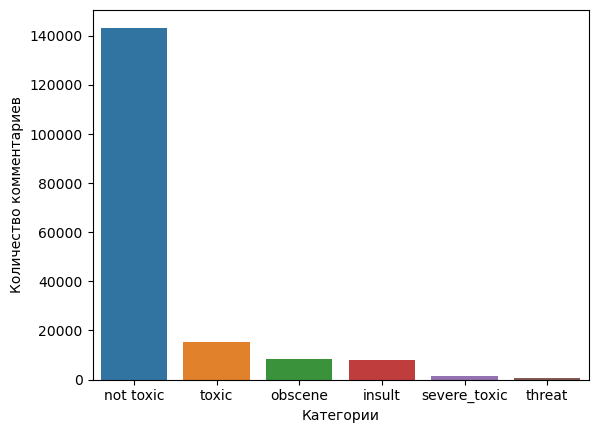

In [3]:
# Код тут

df = pd.read_csv('../datasets/toxic.csv')

df['not toxic'] = 1 - df[df.columns[2:]].max(axis=1)

toxic_cols = ['not toxic', 'toxic', 'obscene', 'insult', 'severe_toxic', 'threat']

toxic_dict = {}

for col in toxic_cols:
    toxic_dict[col] = df[col].value_counts()[1]
    
sns.barplot(x=list(toxic_dict.keys()), y=list(toxic_dict.values()))
plt.xlabel('Категории')
plt.ylabel('Количество комментариев')

In [4]:
toxic_dict

{'not toxic': 143346,
 'toxic': 15294,
 'obscene': 8449,
 'insult': 7877,
 'severe_toxic': 1595,
 'threat': 478}

## Task 2

Используя библиотеку [nltk](https://www.nltk.org/) обработайте тексты комментариев: 
* Приведи текст к нижнему регистру и токенизируй
* Оставь токены содержащие английского алфавита 
* Убери знаки препинания, цифры
* Убери стоп-слова из библиотки nltk

Выведи количество токенов для комментария с индексом `000103f0d9cfb60f`

In [5]:
# Код тут

# добавляю к стоп-словам все слова, состоящие из одной буквы: 
stop_words = stopwords.words('english') + list(string.ascii_lowercase)

df['tokenized_lower'] = df['comment_text'].str.lower().apply(word_tokenize)

df['tokens'] = np.nan

for i in range(len(df['comment_text'])):
    df['tokens'].iloc[i] = [word for word in df['tokenized_lower'].iloc[i] if word not in stop_words and word.isalpha()]
    
len(df[df['id'] == '000103f0d9cfb60f']['tokens'][1])

9

## Task 3

Раздели выборку на тренировачную и тестовоую с параметрами `random_state=21, test_size=0.3, shuffle=True`
Преобразуй тексты комментариев с помощью [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) с количеством признаков равный 3000. \
Выведи размерность тренировачной выборки после преобразования текста.

In [6]:
# Код тут

#X = df['comment_text']

#X = df['tokens']

df['tokens_text'] = [' '.join(text) for text in df['tokens']]

X = df['tokens_text']

y = df[['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'not toxic']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.3, shuffle=True)

vectorizer = TfidfVectorizer(max_features=3000)

X_train = vectorizer.fit_transform(X_train)

X_test = vectorizer.transform(X_test)

X_train.shape

(111699, 3000)

## Task 4

Реши задачу [Multi-Label](https://scikit-learn.org/stable/modules/multiclass.html) классификации используя [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier).
Посчитай значение ROC-AUC для тестовой выборки.

In [7]:
# Код тут

clf = RidgeClassifier(fit_intercept=False)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6886171929810375

## Task 5

Есть посмотреть на тексты токсичных комментариев, то можно заметить, что они могут повторять одни и те же слова. Или там чаще встречается `!` знаки. \
Кроме 'прямых' текстовых признаков, можно использоваться и эту статистику по тексту. Например, долю уникальных слов в тексте комментария или количество пунктуации в тексте.

Придумай не меньше 4х признаков, которые могут помочь в обучении модели. Добавьте их к признакам TF-IDF и обучите модель. 
Получилось ли увеличить качество классификации?

In [8]:
# Код тут

# добавляю признак с длиной коментария: 
df['total_length'] = df['comment_text'].apply(len)

# добавляю признак с количеством слов в комментарии, написанных заглавными буквами: 
df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))

# добавляю признак с количеством восклицательных знаков в комментарии: 
df['exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))

# добавляю признак с количеством пунктуационных знаков в комментарии: 
df['punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in string.punctuation))


X_2 = df[['total_length', 'capitals', 'exclamation_marks', 'punctuation']]

scaler = preprocessing.MinMaxScaler()

names = X_2.columns

X_2_scaled = scaler.fit_transform(X_2)

X_2 = pd.DataFrame(X_2_scaled, columns=names)

X_train_2 = X_2[:111699]

X_train_2_matrix = csr_matrix(X_train_2)

X_train_result = hstack((X_train, X_train_2_matrix))

X_test_2 = X_2[111699:]

X_test_2_matrix = csr_matrix(X_test_2)

X_test_result = hstack((X_test, X_test_2_matrix))


clf = RidgeClassifier(fit_intercept=False)

clf.fit(X_train_result, y_train)

y_pred = clf.predict(X_test_result)

roc_auc_score(y_test, y_pred)

0.6874680505395432

Дополнительно (для общего развития): 

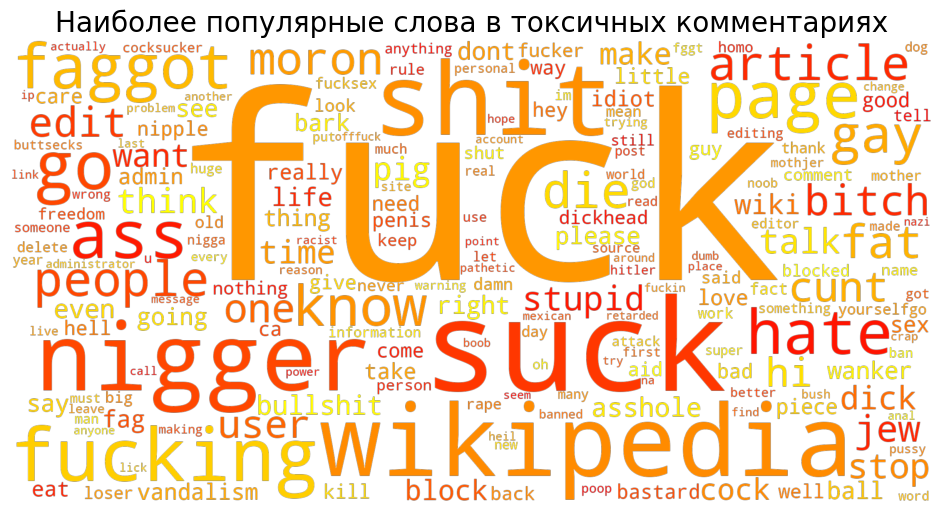

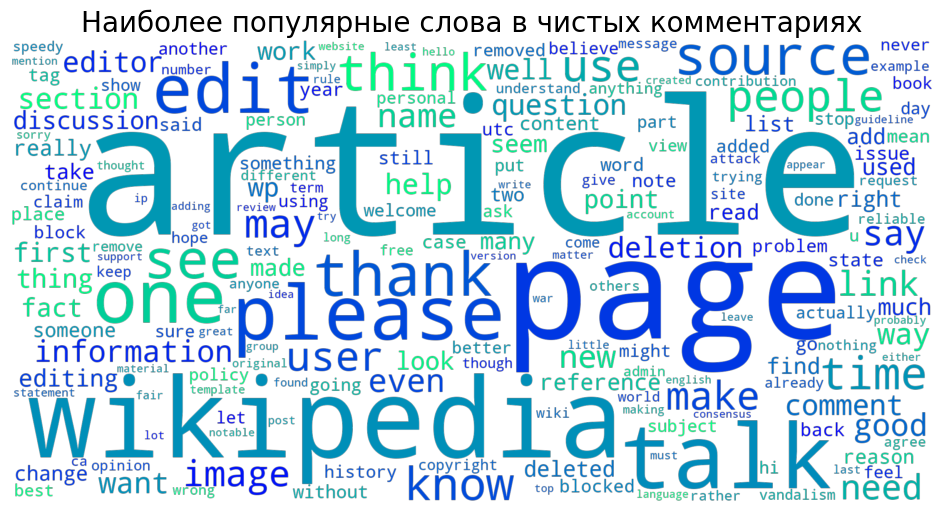

In [9]:
# ради эксперимента можно посмотреть облака самых часто встречающихся слов: 

words_from_toxic_comments = [word for word_list in df[df['not toxic'] == 0]\
                             ['tokens'].values for word in word_list]

words_from_clear_comments = [word for word_list in df[df['not toxic'] == 1]\
                             ['tokens'].values for word in word_list]

toxic_text = ' '.join(words_from_toxic_comments)
clear_text = ' '.join(words_from_clear_comments)

cloud_params = {
    'max_words': 200,
    'regexp': '[a-z]+',
    'collocations': False,
    
    'width': 2400,
    'height': 1200,
    'margin': 5,
    
    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,
 
    'background_color': None,
    'mode': 'RGBA',
    
    'random_state': 42
}

texts = [toxic_text, clear_text]
cmaps = ['autumn', 'winter']
titles = ['токсичных', 'чистых']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title('Наиболее популярные слова в {} комментариях'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear')
#     plt.imsave(title + '.png', word_cloud)